In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import os

from torchsummary import summary
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torchvision import transforms, datasets
from tqdm.notebook import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Forming a dataset

In [4]:
DATASET_PATH = "lfw-deepfunneled"
ATTRIBUTE_PATH = "lfw_attributes.txt"

In [5]:
# original images shape is 250x250
image_transforms = transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize(128),
    transforms.ToTensor()
])

full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=image_transforms)
#  check that all images are in the dataset
assert len(full_dataset.samples) == 13233

batch_size = 32

In [6]:
# num of unique persons
len(full_dataset.classes)

5749

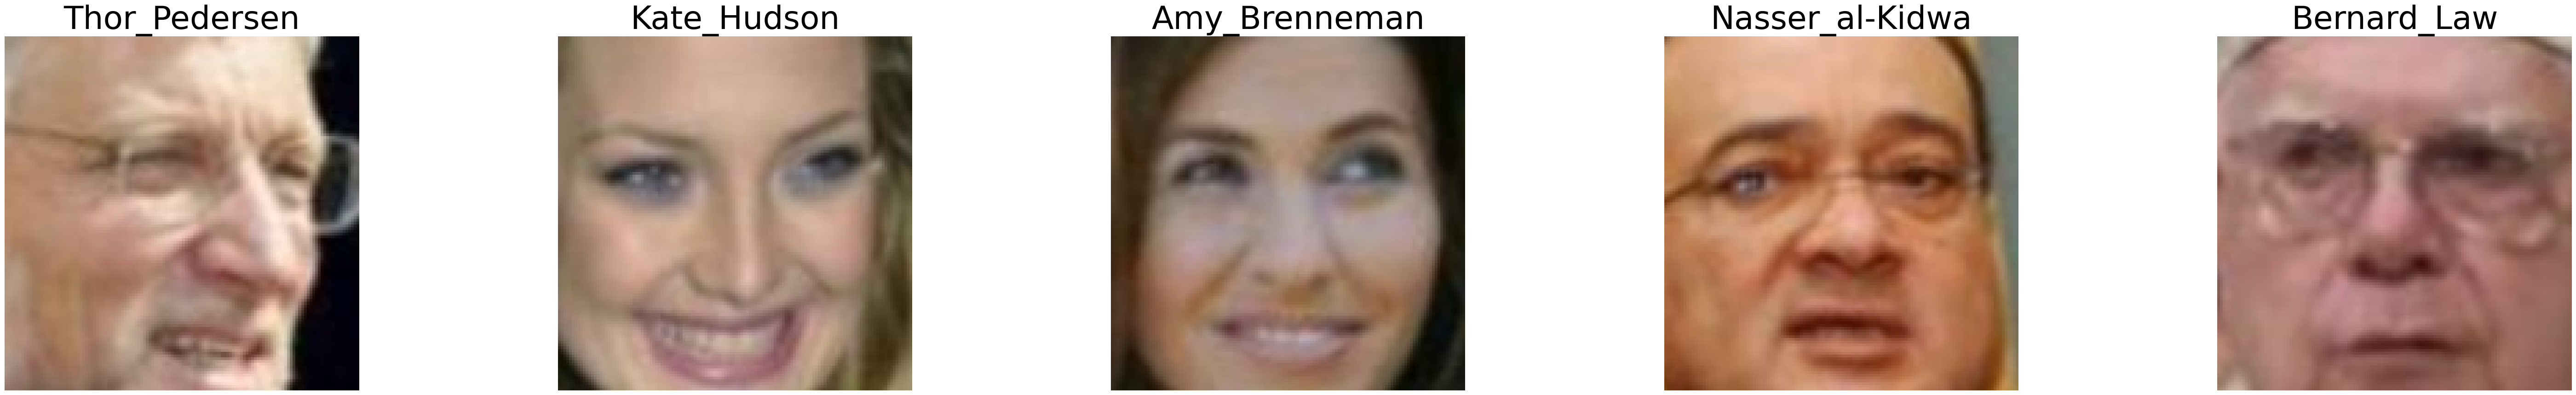

In [7]:
def show_random_images(dataset, num=5):
    plt.figure(figsize=(num * 15, 10))
    indices = np.random.choice(len(dataset), num)
    for i, id in enumerate(indices):
        x, y = dataset[id]
        plt.subplot(1, num, i + 1)
        plt.title(dataset.classes[y], fontsize=50)
        plt.imshow(x.permute(1, 2, 0))
        plt.grid(False)
        plt.axis("off")

show_random_images(full_dataset, 5)

In [8]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [26]:
in_channels = 3
out_channels = 32
kernel_size = 3
latent_dim = 512

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            # size: 128x128, channels: 3
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # size: 64x64, channels: 32
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels * 2, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_features=out_channels * 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # size: 32x32, channels: 64
            nn.Conv2d(in_channels=out_channels * 2, out_channels=out_channels * 4, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_features=out_channels * 4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # size: 16x16, channels: 128
            nn.Flatten(),
            nn.Linear(16 * 16 * out_channels * 4, latent_dim),
            # nn.Dropout(p=0.2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16 * 16 * out_channels * 4),
            nn.Unflatten(1, (out_channels * 4, 16, 16)),
            nn.ConvTranspose2d(in_channels=out_channels * 4, out_channels=out_channels * 2, kernel_size=kernel_size, padding=1, stride=2, output_padding=1),
            nn.BatchNorm2d(num_features=out_channels * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=out_channels * 2, out_channels=out_channels, kernel_size=kernel_size, padding=1, stride=2, output_padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=in_channels, kernel_size=kernel_size, padding=1, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return  encoded, decoded

    def sample(self, X_encoded):
        decoded = self.decoder(X_encoded)
        return decoded

In [27]:
summary(Autoencoder().to(device), (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                  [

In [39]:
def train_loop(model, loader, loss, optimizer):
    loss_accum = 0.0
    total_samples = 0
    model.train()
    for (X, _) in loader:
        X_gpu = X.to(device)
        encoder, decoder = model(X_gpu)
        loss_val = loss(decoder, X_gpu)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        total_samples += X_gpu.shape[0]
        loss_accum += loss_val.item() * X_gpu.shape[0]

    train_loss = loss_accum / total_samples
    return train_loss

def val_loop(model, loader, loss):
    loss_accum = 0.0
    total_samples = 0
    model.eval()

    with torch.no_grad():
        for (X, _) in loader:
            X_gpu = X.to(device)
            encoder, decoder = model(X_gpu)
            loss_val = loss(decoder, X_gpu)

            total_samples += X_gpu.shape[0]
            loss_accum += loss_val.item() * X_gpu.shape[0]

        val_loss = loss_accum / total_samples

    # show one image during training
    im_id = 15
    with torch.no_grad():
        img, label = val_loader.dataset[im_id]
        img_to_model = torch.FloatTensor(img.unsqueeze(0)).to(device)
        encoder, decoder = autoencoder(img_to_model)
        decoded_img = decoder.squeeze(0)

        img = img.to("cpu")
        decoded_img = decoded_img.to("cpu")

        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(decoded_img.permute(1, 2, 0))
        plt.title("Decoded Image")
        plt.axis('off')

        plt.show()
    return val_loss


def train(model, train_loader, val_loader, epochs, save_weights=False, scheduler=False):
    loss = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-5, momentum=0.9)
    if scheduler:
        scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.2, patience=5, min_lr=1e-8)
        scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.90)
    loss_history = []

    with tqdm(desc="epoch", total=epochs) as pbar:
        for epoch in range(epochs):
            train_loss = train_loop(model, train_loader, loss, optimizer)
            val_loss = val_loop(model, val_loader, loss)
            loss_history.append((train_loss, val_loss))

            cur_lr = optimizer.param_groups[0]["lr"]
            scheduler1.step(val_loss)
            scheduler2.step()
            pbar.write(f"Epoch: {epoch + 1} train_loss: {train_loss:.4f} val_loss: {val_loss:.4f}, lr: {cur_lr}")
            pbar.update(1)
            if save_weights and epoch % 20 == 0 and epoch != 0:
                torch.save(model.state_dict(), f'model_epoch_{epoch}.pt')
    return loss_history

In [40]:
autoencoder = Autoencoder()
autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=32768, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=51

In [2]:
history = train(autoencoder, train_loader, val_loader, 20, save_weights=False, scheduler=True)

In [42]:
# save params and load them
autoencoder.load_state_dict(torch.load("512_lat_space_0.0011.pt", weights_only=True))

<All keys matched successfully>

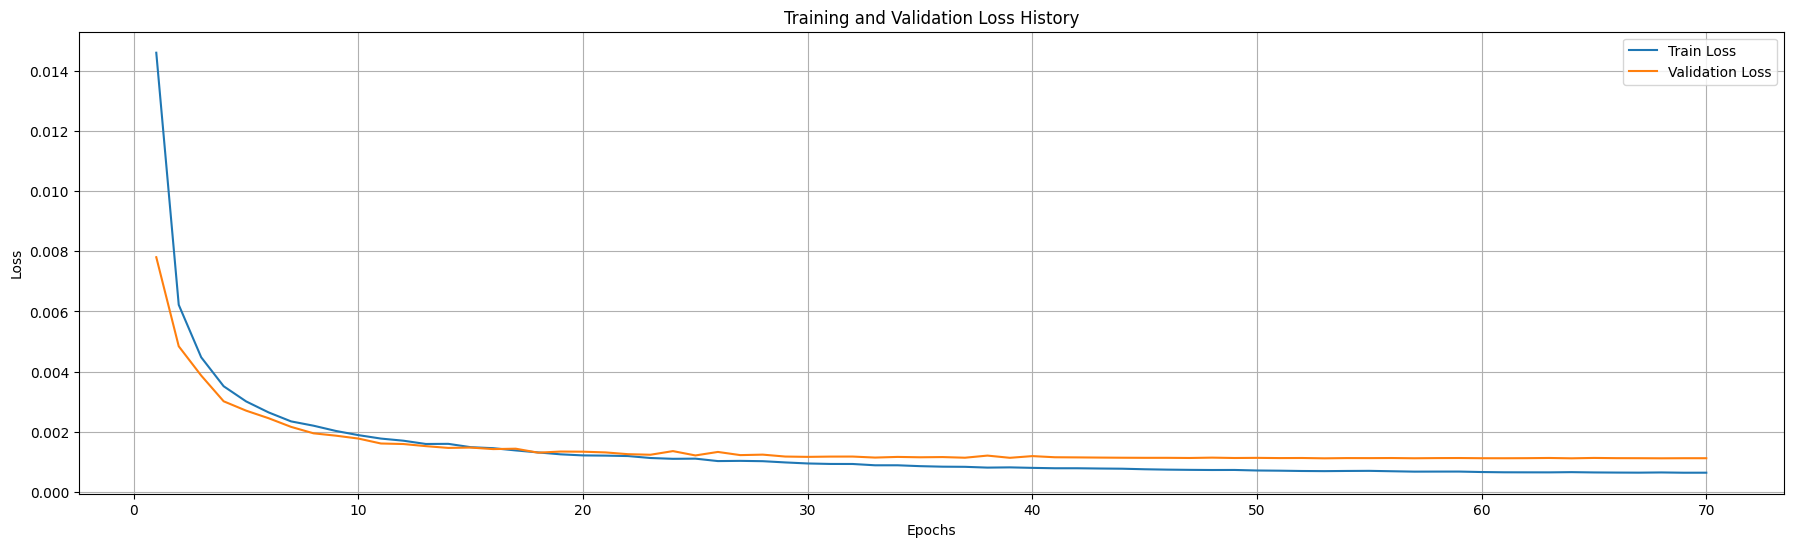

In [44]:
def plot_loss_history(loss_history):
    train_losses = [x[0] for x in loss_history]
    val_losses = [x[1] for x in loss_history]

    epochs = range(1, len(loss_history) + 1)

    plt.figure(figsize=(22, 6))
    plt.plot(epochs, train_losses, label='Train Loss', )
    plt.plot(epochs, val_losses, label='Validation Loss')

    plt.title('Training and Validation Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_history(history)

In [20]:
# visualize results of encoding
def visualize_autoencoder(model, dataset, nimage):
    fig, ax = plt.subplots(nrows=2, ncols=nimage, figsize=(nimage * 12, 16))
    indices = np.random.choice(len(dataset), nimage)
    model.eval()
    for i, id in enumerate(indices):
        with torch.no_grad():
            img, label = dataset[id]
            img_to_model = torch.FloatTensor(img.unsqueeze(0)).to(device)
            encoder, decoder = model(img_to_model)
            decoded_img = decoder.squeeze(0)

            img = img.to("cpu")
            decoded_img = decoded_img.to("cpu")

            ax[0, i].imshow(img.permute(1, 2, 0))
            ax[0, i].set_title(f"{ full_dataset.classes[label]}", fontsize=50)
            ax[0, i].axis("off")

            ax[1, i].imshow(decoded_img.permute(1, 2, 0))
            ax[1, i].set_title(f"decoded", fontsize=50)
            ax[1, i].axis("off")

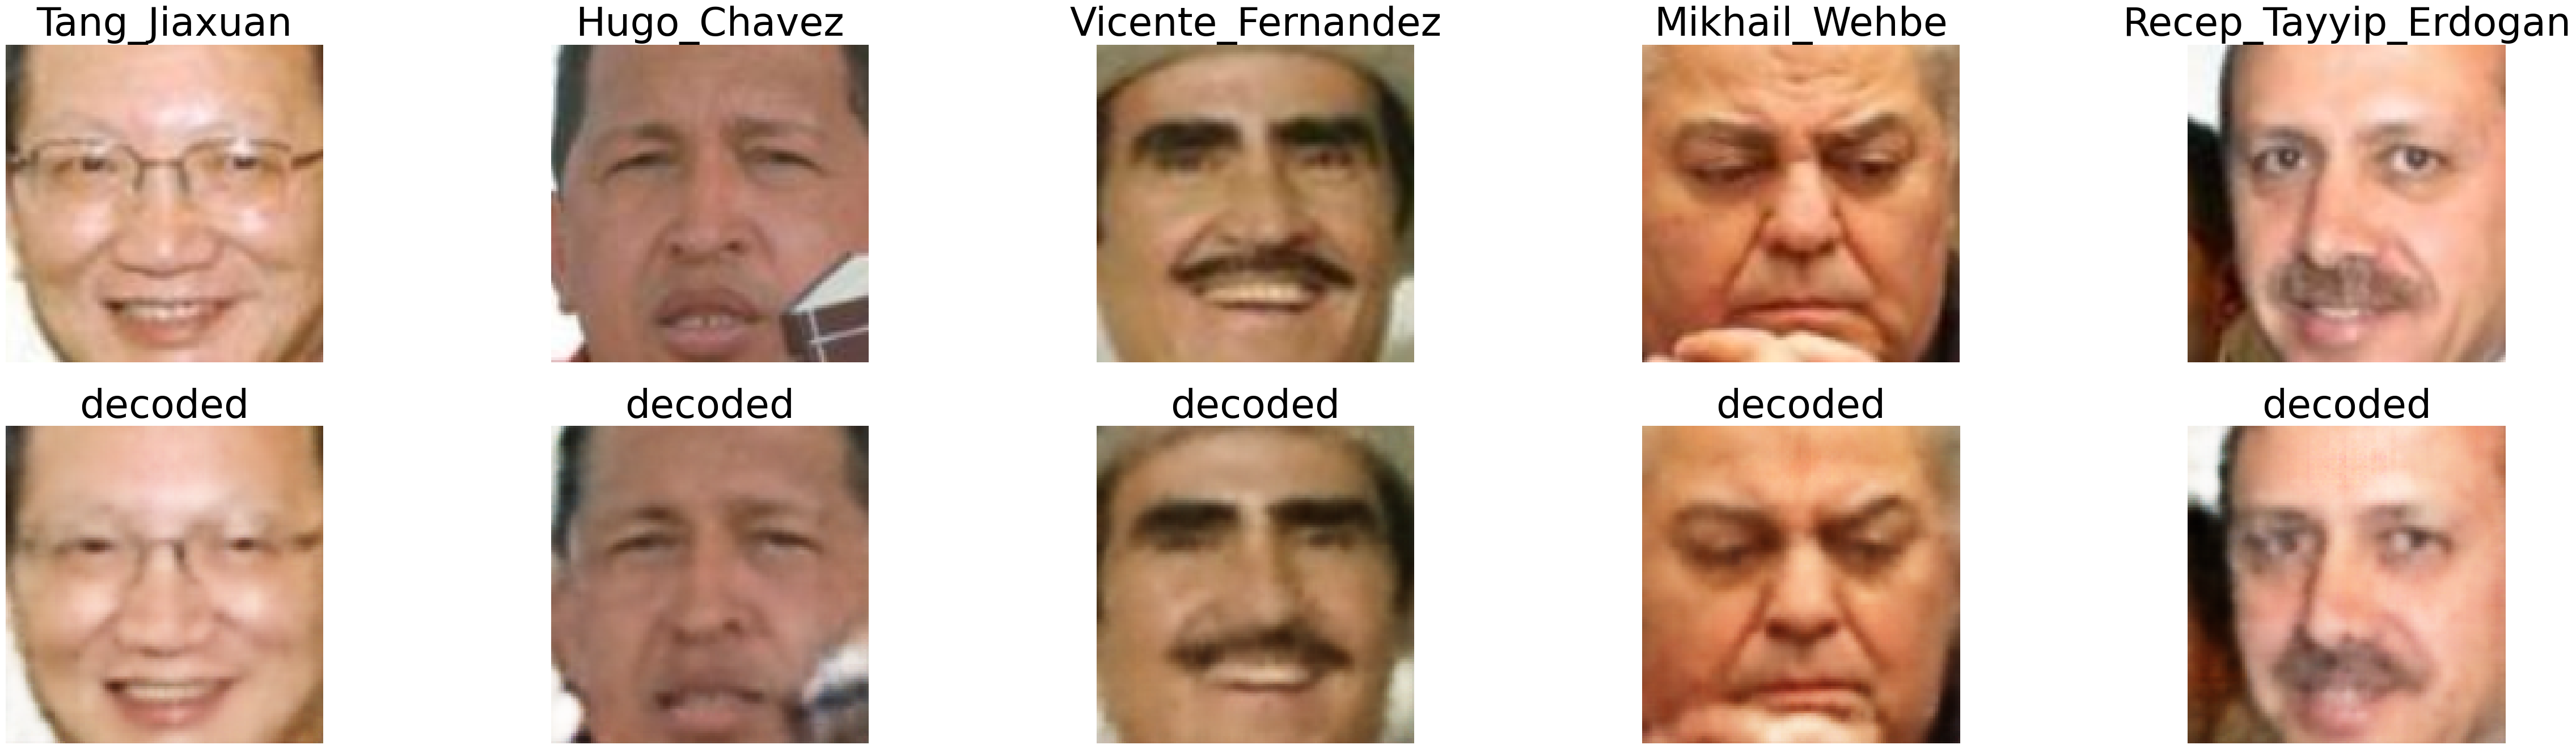

In [46]:
visualize_autoencoder(autoencoder, val_dataset, 5)

## Add some attributes to images (smiles and glasses)

In [35]:
df_attrs = pd.read_csv("lfw_attributes.txt", sep='\t',skiprows=1)
df_attrs.head()

#  person  imagenum      Male     Asian     White     Black  \
0    Aaron Eckhart       1  1.568346 -1.889043  1.737203 -0.929729 -1.471799   
1      Aaron Guiel       1  0.169851 -0.982408  0.422709 -1.282184 -1.360060   
2  Aaron Patterson       1  0.997749 -1.364195 -0.157377 -0.756447 -1.891825   
3    Aaron Peirsol       1  1.122719 -1.997799  1.916144 -2.514214 -2.580071   
4    Aaron Peirsol       2  1.078214 -2.008098  1.676211 -2.278056 -2.651845   

       Baby     Child     Youth  ...  Pale Skin  5 o' Clock Shadow  \
0 -0.195580 -0.835609 -0.351468  ...   1.166118          -1.164916   
1 -0.867002 -0.452293 -0.197521  ...  -0.397680           0.874160   
2 -0.871526 -0.862893  0.031445  ...   1.884745          -0.999765   
3 -1.404239  0.057551  0.000196  ...  -0.176089           1.108125   
4 -1.348408  0.649089  0.017656  ...  -0.955283           0.119113   

   Strong Nose-Mouth Lines  Wearing Lipstick  Flushed Face  High Cheekbones  \
0                -1.139990         -2.371746     -1.299932        -0.414682   
1                -0.945431         -0.268649     -0.006244        -0.030406   
2                -1.359858         -1.912108     -1.095634         0.915126   
3                -1.600944         -3.264613      0.813418         0.308631   
4                -1.128176         -3.161048      0.082680        -0.439614   

   Brown Eyes  Wearing Earrings  Wearing Necktie  Wearing Necklace  
0   -1.144902          0.694007        -0.826609               NaN  
1   -0.480128          0.666760        -0.496559               NaN  
2   -0.572332          0.144262        -0.841231               NaN  
3   -0.848693          0.475941        -0.447025               NaN  
4   -0.359859         -0.760774        -0.410152               NaN  

[5 rows x 76 columns]

In [36]:
df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
df_attrs.head()

person imagenum      Male     Asian     White     Black      Baby  \
0    Aaron Eckhart        1  1.568346 -1.889043  1.737203 -0.929729 -1.471799   
1      Aaron Guiel        1  0.169851 -0.982408  0.422709 -1.282184  -1.36006   
2  Aaron Patterson        1  0.997749 -1.364195 -0.157377 -0.756447 -1.891825   
3    Aaron Peirsol        1  1.122719 -1.997799  1.916144 -2.514214 -2.580071   
4    Aaron Peirsol        2  1.078214 -2.008098  1.676211 -2.278056 -2.651845   

      Child     Youth Middle Aged  ... Pale Skin 5 o' Clock Shadow  \
0  -0.19558 -0.835609   -0.351468  ...  0.361738          1.166118   
1 -0.867002 -0.452293   -0.197521  ... -0.832036          -0.39768   
2 -0.871526 -0.862893    0.031445  ...  1.549743          1.884745   
3 -1.404239  0.057551    0.000196  ...  0.567822         -0.176089   
4 -1.348408  0.649089    0.017656  ... -1.461474         -0.955283   

  Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0               -1.164916         -1.13999    -2.371746       -1.299932   
1                 0.87416        -0.945431    -0.268649       -0.006244   
2               -0.999765        -1.359858    -1.912108       -1.095634   
3                1.108125        -1.600944    -3.264613        0.813418   
4                0.119113        -1.128176    -3.161048         0.08268   

  Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
0  -0.414682        -1.144902        0.694007        -0.826609  
1  -0.030406        -0.480128         0.66676        -0.496559  
2   0.915126        -0.572332        0.144262        -0.841231  
3   0.308631        -0.848693        0.475941        -0.447025  
4  -0.439614        -0.359859       -0.760774        -0.410152  

[5 rows x 75 columns]

In [37]:
# format similar to dataset
df_attrs["person"] = df_attrs["person"].str.replace(" ", "_")

In [38]:
def get_persons_by_attribute(attr, num, margin=20, attr_ascending=False, gender=None):
    """
    returns list of indices in full_dataset with specified attribute

    :param attr: name of attribute in df_attrs.
    :type attr: str
    :param num: number of indices ot find.
    :type num: int
    :param margin: how many elements of a sorted dataframe to skip.
    :type margin: int
    :param attr_ascending: sort in ascending order or not.
    :type attr_ascending: bool
    :param gender: additional sorting by gender
    :type gender: None or str

    :return: list[int]: a list of indices in `full_dataset`
    """
    df_attrs["person"] = df_attrs["person"].str.replace(" ", "_")
    left_border, right_border = margin, margin + num
    if gender == "male":
        filtered_df = df_attrs[df_attrs["Male"] > 1.5]
    elif gender == "female":
        filtered_df = df_attrs[df_attrs["Male"] < -0.5]
    else:
        filtered_df = df_attrs

    attr_ids = filtered_df.sort_values(by=attr, ascending=attr_ascending).iloc[left_border:right_border][["person", "imagenum"]].dropna()
    res_ids = []
    for row in attr_ids.itertuples():
        person, img_num = row.person, row.imagenum
        if row.person in full_dataset.classes:
            class_id = full_dataset.class_to_idx[person]
            for idx, (path, class_idx) in enumerate(full_dataset.samples):
                if class_idx == class_id and path.endswith(str(img_num) + ".jpg"):
                    res_ids.append(idx)
                    break
    return res_ids

In [39]:
def visualize_images(indices):
    for i, id in enumerate(indices):
        img, _ = full_dataset[id]

        plt.subplot(5, 6, i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis("off")
        plt.title(id)

    plt.tight_layout()
    plt.show()

In [42]:
smile_indices = get_persons_by_attribute(attr="Smiling", num=30, margin=30, gender="male")

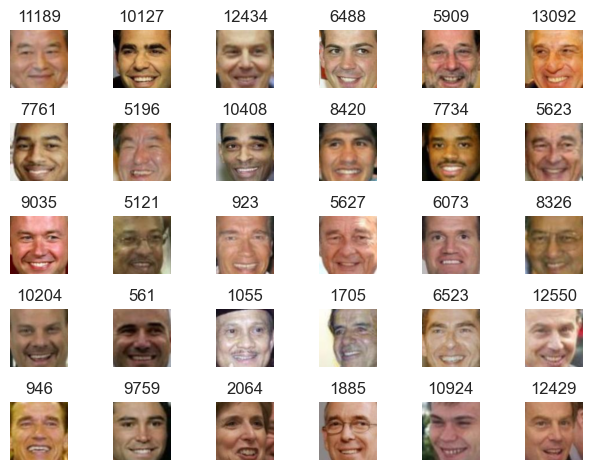

In [18]:
visualize_images(smile_indices)

In [43]:
sad_indices = get_persons_by_attribute(attr="Smiling", num=30, margin=120, attr_ascending=True, gender="male")

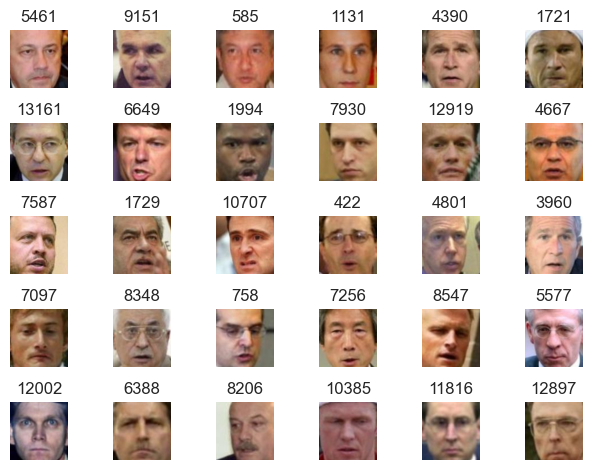

In [20]:
visualize_images(sad_indices)

In [44]:
# encode images to latent space
def encode_images(indices):
    encoded_images = torch.FloatTensor().to(device)
    for id in indices:
        img, _ = full_dataset[id]
        img_to_model = torch.FloatTensor(img.unsqueeze(0)).to(device)
        with torch.no_grad():
            encoded, _ = autoencoder(img_to_model)
            encoded_images = torch.cat((encoded_images, encoded))
    return encoded_images

In [45]:
encoded_smile = encode_images(smile_indices)
encoded_sad = encode_images(sad_indices)

In [46]:
smile_mean = torch.mean(encoded_smile, axis=0)
sad_mean = torch.mean(encoded_sad, axis=0)
smile_vector = smile_mean - sad_mean

In [47]:
def visualize_decoding_with_attr(attr_vector, indices, subtraction=False):
    fig, ax = plt.subplots(nrows=2, ncols=len(indices), figsize=(len(indices) * 12, 16))
    encoded = encode_images(indices)
    if subtraction:
        img_with_attr = encoded - attr_vector
    else:
        img_with_attr = encoded + attr_vector
    decoded_images = autoencoder.sample(img_with_attr)
    for i, id in enumerate(indices):
        with torch.no_grad():
            img, no_attr_decoded = full_dataset[id]
            decoded_img = decoded_images[i]

            img = img.to("cpu")
            decoded_img = decoded_img.to("cpu")

            ax[0, i].imshow(img.permute(1, 2, 0))
            ax[0, i].axis("off")

            ax[1, i].imshow(decoded_img.permute(1, 2, 0))
            ax[1, i].axis("off")


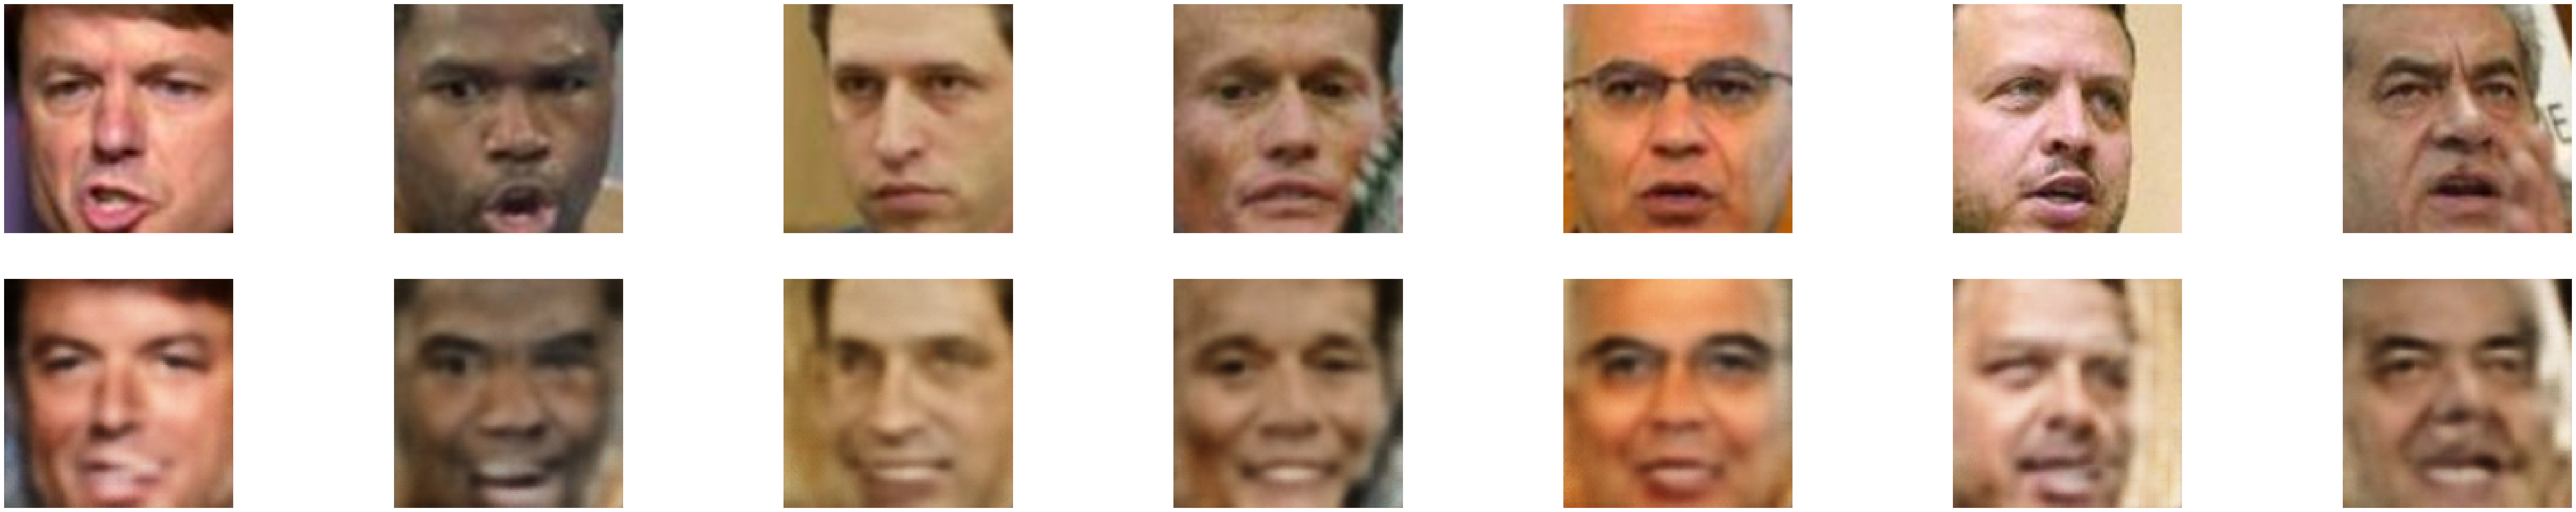

In [48]:
visualize_decoding_with_attr(smile_vector, sad_indices[7:14])

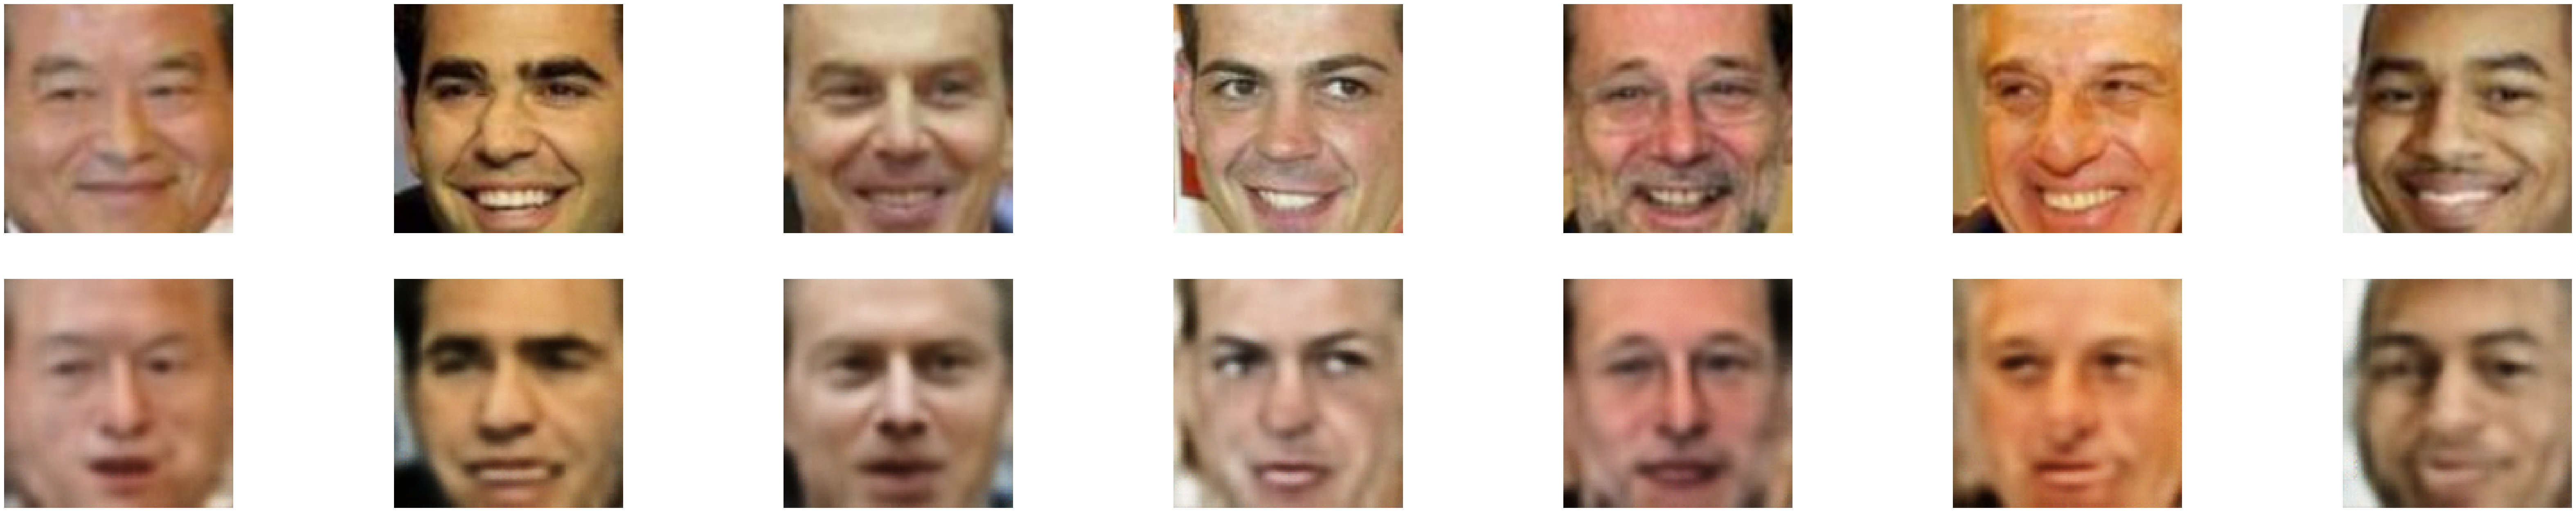

In [49]:
visualize_decoding_with_attr(smile_vector, smile_indices[0:7], subtraction=True)

In [50]:
sunglasses_indices = get_persons_by_attribute(attr="Sunglasses", num=30, margin=10)

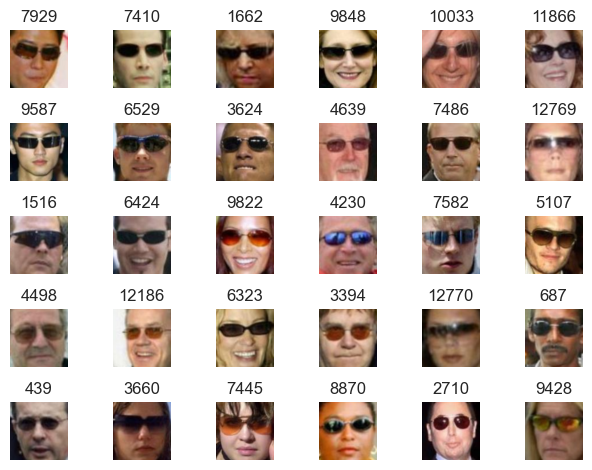

In [31]:
visualize_images(sunglasses_indices)

In [51]:
no_sunglasses_indices = get_persons_by_attribute(attr="Sunglasses", num=30, margin=20, attr_ascending=True)

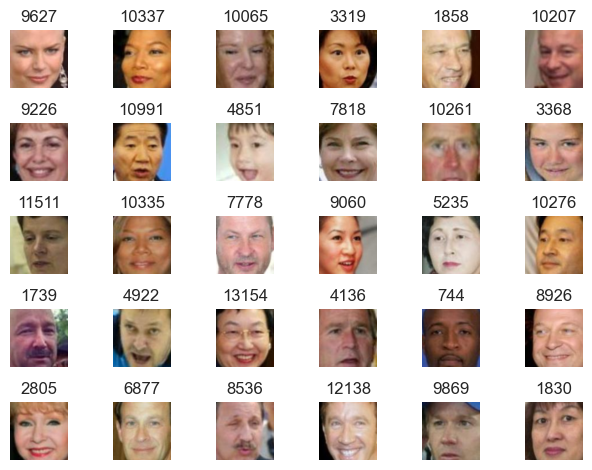

In [33]:
visualize_images(no_sunglasses_indices)

In [52]:
encoded_sunglasses = encode_images(sunglasses_indices)
encoded_no_sunglasses = encode_images(no_sunglasses_indices)

sunglasses_mean = torch.mean(encoded_sunglasses, axis=0)
no_sunglasses_mean = torch.mean(encoded_no_sunglasses, axis=0)
sunglasses_vector = sunglasses_mean - no_sunglasses_mean

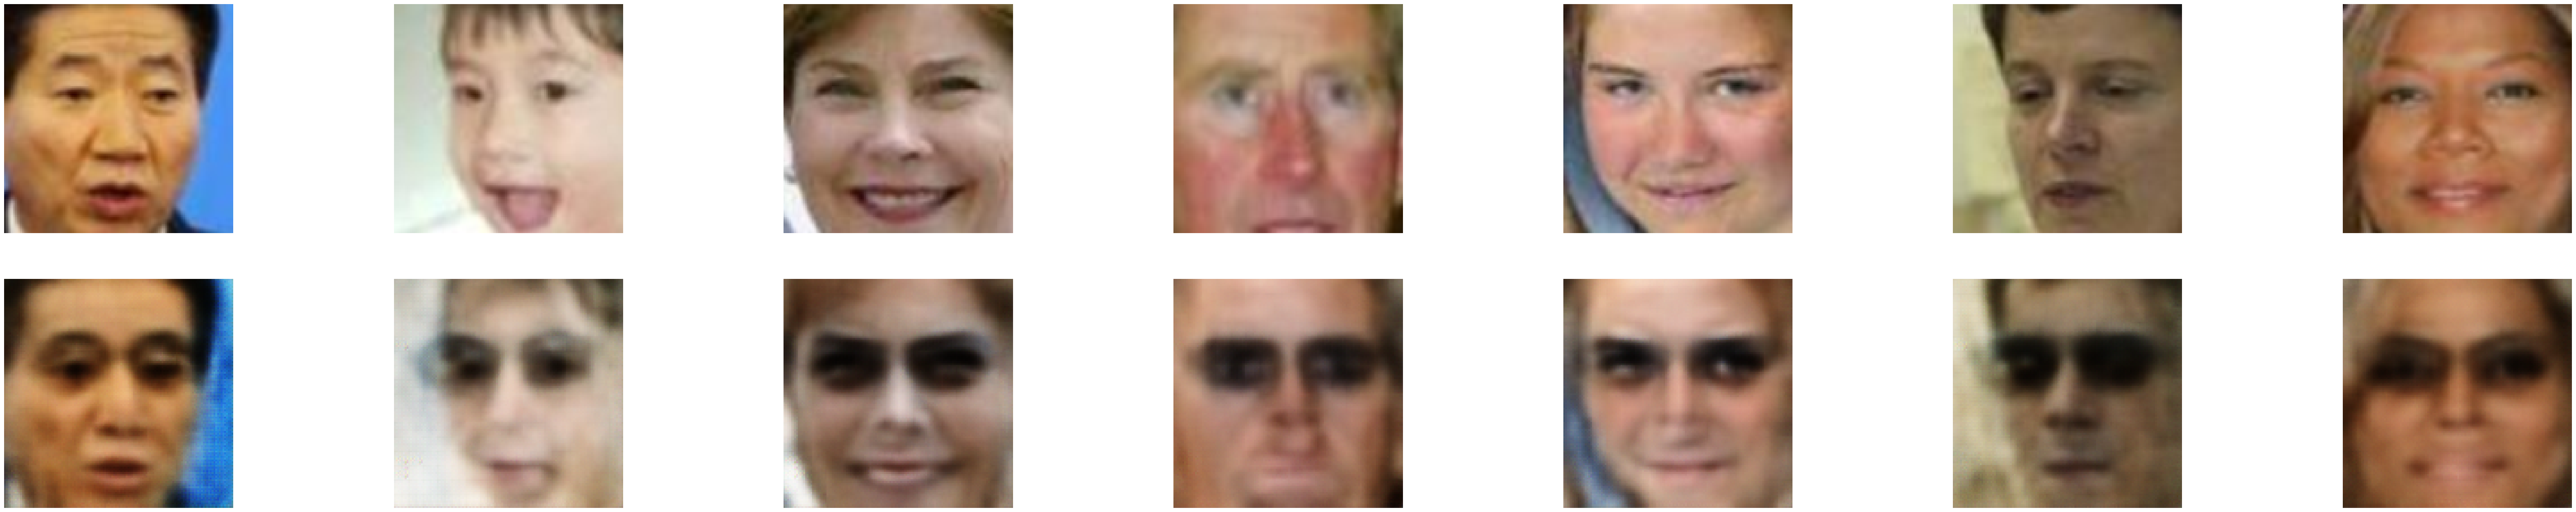

In [53]:
visualize_decoding_with_attr(sunglasses_vector, no_sunglasses_indices[7:14])

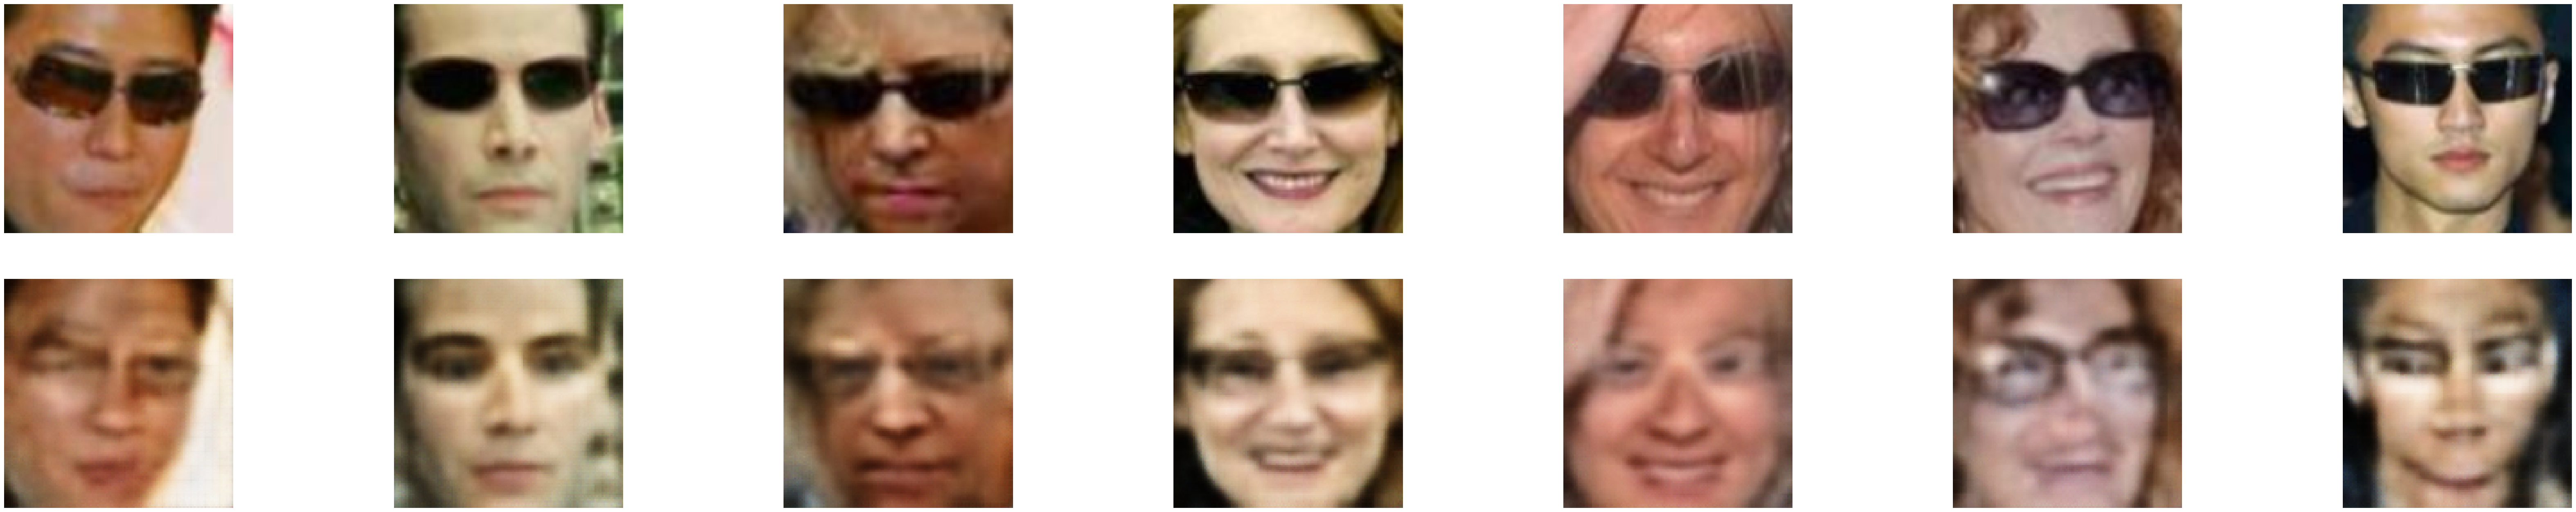

In [54]:
visualize_decoding_with_attr(sunglasses_vector, sunglasses_indices[0:7], subtraction=True)